In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('E:\\Python\\NLP-2\\banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:00, 1663.27it/s]


In [4]:
responses[67]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Звонки по ночам.',
 'num_comments': 0,
 'bank_license': 'лицензия № 3279',
 'author': 'HAB728',
 'bank_name': 'Национальный Банк «Траст»',
 'datetime': '2015-06-07 21:37:17',
 'text': 'Уважаемый банк и г-жа станецкая, скажите, в какие рамки закона попадают звонки по ночам, в час ночи, в три ночи ...в выходные дни. Скрин не нашла как прицепить. Отправлю заодно в роскомнадзор и цб. \xa0Приятна забота, но услугу "разбуди меня" я не заказывала. Если только с завтраком в номер и на югах. А так не смешно, дамы и господа.',
 'rating_grade': None}

# Часть 1. Анализ текстов

### Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
df['city'].value_counts()

г. Москва                                55354
г. Санкт-Петербург                       14342
г. Екатеринбург                           2337
г. Новосибирск                            2300
г. Нижний Новгород                        1976
                                         ...  
г. Республика Карелия петрозаводск           1
г. Москва, Гончарная ул.                     1
г. Семилуки, Воронеж                         1
г. Самара Чернореченская 42а (Самара)        1
г. Непонятно                                 1
Name: city, Length: 5823, dtype: int64

In [8]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Традо-Банк              1
УИК-Банк                1
Курган                  1
Рублевский              1
Сибнефтебанк            1
Name: bank_name, Length: 670, dtype: int64

In [9]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

### Постройте гистограмы длин слов в символах и в словах

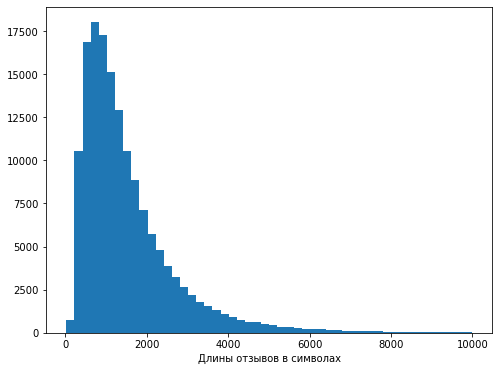

In [10]:
len_c = df.text.apply(len)
rcParams['figure.figsize'] = 8, 6
len_c[len_c<10000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

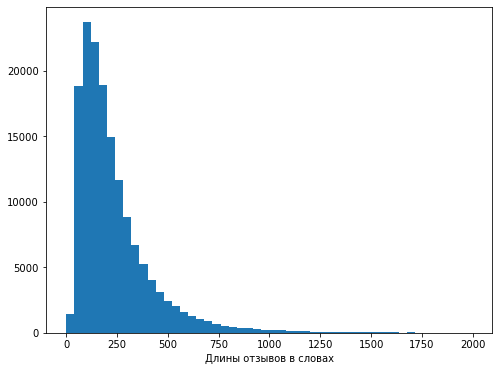

In [11]:
len_t = df.text.str.split().apply(len)
rcParams['figure.figsize'] = 8, 6
len_t[len_t<2000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

### Найдите 10 самых частых:
#### слов
#### слов без стоп-слов
#### лемм
#### существительных

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
from nltk.tokenize import word_tokenize

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [16]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [17]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [18]:
from tqdm import tqdm_notebook as tqdm
from collections import Counter

cnt = Counter()
n_types = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

for i in cnt.most_common(10):
    print(i)

<ipython-input-18-bafe643cd23a>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


## Cлова без стоп-слов

In [19]:
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [20]:
df['text_tokinized_stop_worlds'] = df.text_tokinized.str.lower().apply(remove_stopwords)


In [21]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...


In [22]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_stop_worlds'].split()
    tokens_all+=tokens
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)

<ipython-input-22-5e7bdfedadc5>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


## Леммы


In [31]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [32]:
m = Mystem()

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [33]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'г']

def remove_stoplemmas(text, mystoplemmas=mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [34]:
df['lemma'] = df['text_tokinized_stop_worlds'].apply(lemmatize)

In [35]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...


In [37]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)

<ipython-input-37-d63bfb088876>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('банк', 229140)
('карта', 108102)
('мой', 61840)
('день', 61816)
('деньги', 59356)
('кредит', 57684)
('который', 53977)
('сотрудник', 53725)
('клиент', 48068)
('отделение', 47088)


## Существительные


In [32]:
def to_nouns(text, mystem=m):
    m=MorphAnalyzer()
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []

to_nouns(df.lemma.iloc[1])

'день держатель карта сбербанк россия год фамилия банк документ копия паспорт свидетельство брак карта фамилия муж токарева мария александровна секлетина необходимость услуга сбербанк страница карта специалист отделение сбербанк база банк фамилия секлетина скан документ контакт звонок ч время ситуация база секлетина карта фамилия токарева связь истечение срок обслуживание документ копия паспорт свидетельство брак результат ноль ситуация уважение токарев мария александровна'

In [ ]:
from multiprocessing import Pool

with Pool() as p:
    df['nouns']=p.map(to_nouns,df.lemma)

In [ ]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))

for i in cnt_noun.most_common(10):
    print(i

## 4. Постройте кривую Ципфа


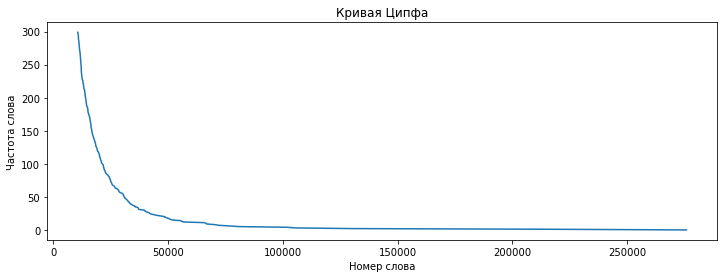

In [23]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(n_tokens,n_types)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.show()

## 5. Ответьте на следующие вопросы:
какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?

In [39]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [40]:
print('Слово "сотрудник" встречается -"',Freq_Dist['сотрудник'],'раз')
print('Слово "клиент" встречается -"',Freq_Dist['клиент'],'раз')

Слово "сотрудник" встречается -" 53725 раз
Слово "клиент" встречается -" 48068 раз


In [41]:
print('Слово "мошенничество" встречается -"',Freq_Dist['мошенничество'],'раз')
print('Слово "доверие" встречается -"',Freq_Dist['доверие'],'раз')

Слово "мошенничество" встречается -" 1225 раз
Слово "доверие" встречается -" 767 раз


### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [42]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [43]:
num=10000

df_sample = df[(df.rating_grade==1)].sample(n=num).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=num))

df_sample.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [44]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]
    
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
        
    tokens_by_topic.append(tokens)

In [45]:
df_sample.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds,lemma
16358,г. Орел,False,Получение перевода за 800 рублей,0,лицензия № 2412,gater91,Пробизнесбанк,2015-01-25 11:38:00,Мне выслали денежный перевод по Золотой Короне...,1.0,мне выслали денежный перевод по золотой короне...,выслали денежный перевод золотой короне посмот...,высылать денежный перевод золотой корона посмо...
38608,г. Москва,False,"""Ваш звонок очень важен для нас""",1,лицензия № 2272,damirsalihov,Росбанк,2014-08-05 14:06:00,В недалеком 2011 году ещё до окончательного сл...,1.0,в недалеком году ещ до окончательного слияния ...,недалеком году ещ окончательного слияния росба...,недалекий год ещ окончательный слияние росбанк...
46859,г. Москва,False,Неделю не могут открыть счёт!,3,лицензия № 1,jazzy,ЮниКредит Банк,2014-05-21 17:51:00,"Я являюсь клиентом банка, как частное лицо, уж...",1.0,я являюсь клиентом банка как частное лицо уже ...,являюсь клиентом банка частное лицо лет раньше...,являться клиент банк частный лицо год рано ник...


### Униграммы

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [47]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,банк
1,карта,карта
2,клиент,день
3,вклад,деньги
4,очень,мой
5,сотрудник,отделение
6,день,сотрудник
7,отделение,который
8,который,кредит
9,мой,сказать


In [48]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [49]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
31,быстро,средство
32,банка,номер
37,минута,месяц
39,отзыв,звонок
50,помогать,почему
51,первый,говорить
53,несколько,информация
54,пользоваться,срок
57,решение,смс
59,менеджер,банкомат


### Биграммы

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [51]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,другой банк,денежный средство
2,сотрудник банк,отделение банк
3,клиент банк,горячий линия
4,кредитный карта,кредитный карта
5,открывать вклад,написать заявление
6,являться клиент,ваш банк
7,добрый день,добрый день
8,отделение банк,колл центр
9,альфа банк,рабочий день


In [52]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [53]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
18,мой вопрос,получать ответ
21,банк очень,отделение сбербанк
24,приятно удивлять,течение день
28,открытие вклад,мой заявление
30,отношение клиент,писать заявление
31,очень быстро,мой карта
32,год назад,ежемесячный платеж
36,огромный спасибо,свой деньги
38,работа банк,погашение кредит
39,администратор уважать,деньги счет


# Часть 2. Тематическое моделирование [20/100]

### Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
###  Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

In [56]:
pip install gensim 

In [57]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [59]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [60]:
random.seed(11)

In [61]:
lda = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

C:\Users\SD\anaconda3\lib\site-packages\gensim\models\ldamodel.py:846: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [62]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)

[(17,
  '0.012*"курс" + 0.010*"валюта" + 0.008*"рубль" + 0.008*"доллар" + 0.007*"евро" + 0.007*"сч" + 0.005*"валютный" + 0.003*"конвертация" + 0.003*"рублевый" + 0.002*"обмен"'),
 (6,
  '0.032*"платеж" + 0.013*"оплата" + 0.011*"оплачивать" + 0.009*"терминал" + 0.006*"квитанция" + 0.006*"реквизит" + 0.006*"траст" + 0.005*"получатель" + 0.004*"платежный" + 0.002*"платежок"'),
 (0,
  '0.035*"отделение" + 0.029*"сотрудник" + 0.017*"заявление" + 0.016*"обращаться" + 0.015*"мой" + 0.014*"банк" + 0.014*"сбербанк" + 0.013*"получать" + 0.013*"офис" + 0.011*"вопрос"'),
 (9,
  '0.069*"банк" + 0.020*"клиент" + 0.013*"вклад" + 0.011*"очень" + 0.010*"свой" + 0.009*"который" + 0.008*"год" + 0.007*"время" + 0.007*"такой" + 0.007*"банка"'),
 (11,
  '0.018*"сказать" + 0.014*"день" + 0.013*"приходить" + 0.011*"деньги" + 0.009*"мочь" + 0.009*"банк" + 0.009*"говорить" + 0.009*"который" + 0.008*"позвонить" + 0.008*"звонить"')]

In [ ]:
Обмен валют
Покупка по акции, что-то связанное баллами карты
Заявка в тех. поддержку банка
Консультации в банке
Проблема пастоянного клиента с банком

In [63]:
lda15 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=30, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [64]:
# 30 тем, рандомная выборка 5
lda15.show_topics(5)

[(18,
  '0.026*"выписка" + 0.006*"печать" + 0.004*"фирма" + 0.003*"директор" + 0.002*"нотариус" + 0.002*"подпись" + 0.002*"бла" + 0.002*"образец" + 0.002*"бухгалтер" + 0.001*"гибдд"'),
 (14,
  '0.043*"р" + 0.013*"процент" + 0.008*"начислять" + 0.006*"начисление" + 0.004*"начисляться" + 0.004*"расчет" + 0.001*"калькулятор" + 0.001*"расписка" + 0.001*"сверх" + 0.001*"компенсация"'),
 (27,
  '0.067*"банк" + 0.031*"клиент" + 0.019*"очень" + 0.010*"свой" + 0.009*"работа" + 0.009*"время" + 0.009*"сотрудник" + 0.009*"вопрос" + 0.009*"год" + 0.009*"который"'),
 (15,
  '0.029*"день" + 0.028*"банк" + 0.022*"отделение" + 0.021*"сотрудник" + 0.017*"вопрос" + 0.015*"обращаться" + 0.014*"ответ" + 0.014*"сообщать" + 0.012*"позвонить" + 0.012*"мой"'),
 (20,
  '0.029*"банк" + 0.023*"деньги" + 0.021*"сказать" + 0.013*"приходить" + 0.012*"день" + 0.010*"говорить" + 0.010*"такой" + 0.010*"который" + 0.010*"мочь" + 0.008*"мой"')]

In [ ]:
Открытие депозита
Кредит, страховка, что-то связанное с квартирой
Очередь в банке
Звонок в банке
Вопрос клиента сотруднику банка

In [66]:
lda10 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=10, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [67]:
# 10 тем
lda10.show_topics(5)

[(0,
  '0.036*"вклад" + 0.009*"открывать" + 0.006*"процент" + 0.004*"курс" + 0.004*"валюта" + 0.004*"депозит" + 0.004*"вкладчик" + 0.004*"сумма" + 0.003*"доллар" + 0.003*"открытие"'),
 (7,
  '0.017*"договор" + 0.007*"страхование" + 0.006*"рф" + 0.005*"банк" + 0.005*"право" + 0.005*"страховой" + 0.005*"закон" + 0.004*"средство" + 0.003*"условие" + 0.003*"услуга"'),
 (3,
  '0.035*"деньги" + 0.023*"счет" + 0.013*"день" + 0.012*"средство" + 0.010*"банк" + 0.008*"сумма" + 0.008*"платеж" + 0.008*"сбербанк" + 0.008*"мой" + 0.008*"перевод"'),
 (9,
  '0.039*"банк" + 0.016*"клиент" + 0.009*"свой" + 0.008*"очень" + 0.007*"который" + 0.007*"такой" + 0.006*"время" + 0.006*"работа" + 0.005*"сотрудник" + 0.005*"год"'),
 (6,
  '0.015*"отделение" + 0.015*"карта" + 0.013*"сказать" + 0.010*"банк" + 0.009*"день" + 0.009*"приходить" + 0.008*"получать" + 0.007*"сотрудник" + 0.007*"позвонить" + 0.007*"офис"')]

In [ ]:
Заявка на кредитный догово
Открытие вклада
Претензия клиента банку сбербанка
Вопрос в поддержку банка
Звонок клиента в банк

# Часть 3. Классификация текстов [40/100]


Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

Ниже написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [110]:
df_sample.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds,lemma
16358,г. Орел,False,Получение перевода за 800 рублей,0,лицензия № 2412,gater91,Пробизнесбанк,2015-01-25 11:38:00,Мне выслали денежный перевод по Золотой Короне...,1.0,мне выслали денежный перевод по золотой короне...,выслали денежный перевод золотой короне посмот...,высылать денежный перевод золотой корона посмо...
38608,г. Москва,False,"""Ваш звонок очень важен для нас""",1,лицензия № 2272,damirsalihov,Росбанк,2014-08-05 14:06:00,В недалеком 2011 году ещё до окончательного сл...,1.0,в недалеком году ещ до окончательного слияния ...,недалеком году ещ окончательного слияния росба...,недалекий год ещ окончательный слияние росбанк...
46859,г. Москва,False,Неделю не могут открыть счёт!,3,лицензия № 1,jazzy,ЮниКредит Банк,2014-05-21 17:51:00,"Я являюсь клиентом банка, как частное лицо, уж...",1.0,я являюсь клиентом банка как частное лицо уже ...,являюсь клиентом банка частное лицо лет раньше...,являться клиент банк частный лицо год рано ник...


In [112]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 16358 to 132490
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        15541 non-null  object 
 1   rating_not_checked          20000 non-null  bool   
 2   title                       20000 non-null  object 
 3   num_comments                20000 non-null  int64  
 4   bank_license                20000 non-null  object 
 5   author                      19996 non-null  object 
 6   bank_name                   20000 non-null  object 
 7   datetime                    20000 non-null  object 
 8   text                        20000 non-null  object 
 9   rating_grade                20000 non-null  float64
 10  text_tokinized              20000 non-null  object 
 11  text_tokinized_stop_worlds  20000 non-null  object 
 12  lemma                       20000 non-null  object 
dtypes: bool(1), float64(1), in

In [113]:
df_sample.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [114]:
df_sample.columns

Index(['city', 'rating_not_checked', 'title', 'num_comments', 'bank_license',
       'author', 'bank_name', 'datetime', 'text', 'rating_grade',
       'text_tokinized', 'text_tokinized_stop_worlds', 'lemma'],
      dtype='object')

In [115]:
X = df_sample['lemma'].values
y = df_sample.rating_grade.values

In [116]:
X.shape, y.shape

((20000,), (20000,))

In [117]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000,), (6000,), (14000,), (6000,))

In [120]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 𝑛 -грам. (Ниже написан примерный Pipeline для классификации текстов).

In [121]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])

In [122]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

In [123]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1)

In [124]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


C:\Users\SD\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\SD\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.63457135 0.60735708 0.54850009 0.63457135 0.60735708 0.54850009
 0.63457135 0.60735708 0.54850009 0.59071424 0.63328573 0.64235723
 0.59071424 0.63328573 0.64235723 0.59292855 0.63328573 0.64235723
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.644928

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'vect__analyzer': ['word', 'char'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [125]:
# print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.646


In [126]:
predictions=grid_cntv.best_estimator_.predict(X_test)

In [127]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.76
Recall:      0.65
F1_score:    0.61
Accuracy:    0.65


In [128]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.32      0.48      2966
         5.0       0.59      0.98      0.74      3034

    accuracy                           0.65      6000
   macro avg       0.76      0.65      0.61      6000
weighted avg       0.76      0.65      0.61      6000



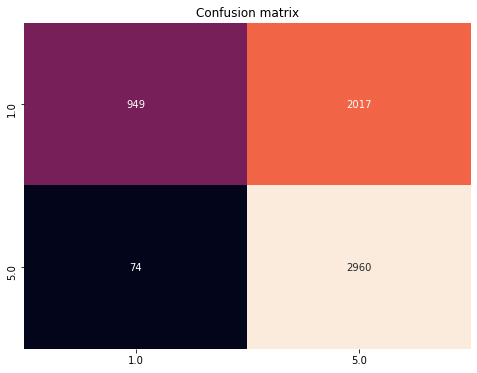

In [129]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()


### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: 𝑡𝑓−𝑖𝑑𝑓 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации. (Эта часть задания может быть сделана с использованием sklearn).

1-ый вариант
𝑡𝑓−𝑖𝑑𝑓

In [130]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [131]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [132]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


C:\Users\SD\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.50285712 0.50242857 0.50242857 0.50285712 0.50242857 0.50242857
 0.50285712 0.50242857 0.50242857 0.56428555 0.50242857 0.50242857
 0.56428555 0.50242857 0.50242857 0.56428555 0.50242857 0.50242857
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.58199982 0.50942859 0.50271431 0.58199982 0.50942859 0.50271431
 0.58199982 0.50942859 0.50271431 0.57957124 0.52228584 0.5067857
 0.57957124 0.52228584 0.5067857  0.57957124 0.52228584 0.5067857
        nan        nan        nan        nan        nan   

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'tfidf__use_idf': (True, False),
                         'vect__analyzer': ['word'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [133]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.649


In [134]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)


In [135]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.76
Recall:      0.65
F1_score:    0.61
Accuracy:    0.65


In [136]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.33      0.48      2966
         5.0       0.60      0.98      0.74      3034

    accuracy                           0.65      6000
   macro avg       0.76      0.65      0.61      6000
weighted avg       0.76      0.65      0.61      6000



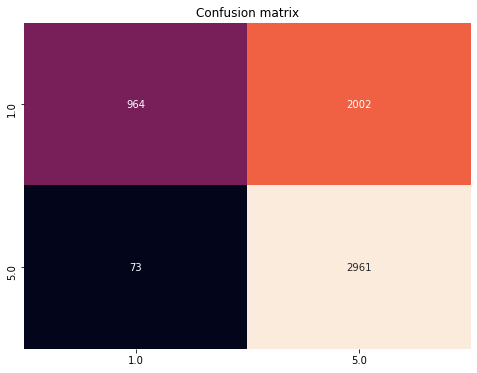

In [137]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### Cингулярное разложение



In [138]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [139]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [140]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)


Fitting 3 folds for each of 210 candidates, totalling 630 fits


C:\Users\SD\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.50242857 0.50242857 0.50242857
 0.50242857 0.50242857 0.50242857 0.50278571 0.50242857 0.50242857
 0.50278571 0.50242857 0.50242857 0.50285714 0.50242857 0.50242857
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.57357118 0.5044285  0.50242857
 0.57628545 0.50414282 0.50242857 0.58049982 0.5062143  0.50242857
 0.58078559 0.50764282 0.50242857 0.5815713  0.50828577 0.50242857
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.60035692 0.59049974 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('tsvd', TruncatedSVD()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'tsvd__n_components': [5, 10, 25, 50, 100],
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [141]:
# print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.647


In [142]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)


In [143]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.76
Recall:      0.65
F1_score:    0.61
Accuracy:    0.65


In [144]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

         1.0       0.93      0.32      0.48      2966
         5.0       0.59      0.98      0.74      3034

    accuracy                           0.65      6000
   macro avg       0.76      0.65      0.61      6000
weighted avg       0.76      0.65      0.61      6000



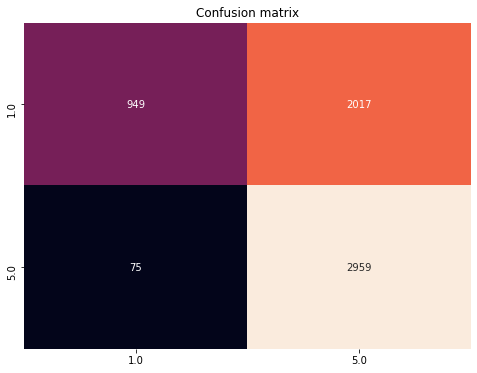

In [145]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### 2-ой вариант
LDA

In [157]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression(C=1, penalty='l1', solver='liblinear'))]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1']
}

scores=['accuracy', 'f1']

In [158]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [159]:
grid_tf_idf_LDA.fit(X_train, y_train)


Fitting 3 folds for each of 21 candidates, totalling 63 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('lda', LatentDirichletAllocation()),
                                       ('clf',
                                        LogisticRegression(C=1, penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1'],
                         'lda__n_components': [25, 50, 100],
                         'vect__analyzer': ['word'], 'vect__max_df': [0.75],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [160]:
# print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.636


In [161]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)


In [162]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.74
Recall:      0.64
F1_score:    0.60
Accuracy:    0.64


In [163]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

         1.0       0.90      0.31      0.46      2966
         5.0       0.59      0.97      0.73      3034

    accuracy                           0.64      6000
   macro avg       0.74      0.64      0.60      6000
weighted avg       0.74      0.64      0.60      6000



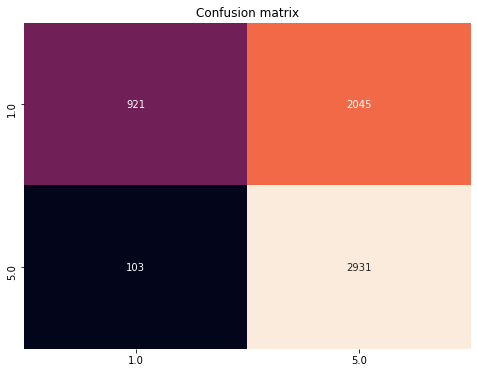

In [164]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

## Итого:


In [165]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'), 
        accuracy_score(y_test, predictions)))

cntv
f1_score:  0.607
Accuracy:  0.607


tf_idf
f1_score:  0.611
Accuracy:  0.611


tf_idf_TruncatedSVD
f1_score:  0.607
Accuracy:  0.607


tf_idf_LDA
f1_score:  0.597
Accuracy:  0.597




𝑡𝑓−𝑖𝑑𝑓 наиболее удачная модель



In [166]:
pass